In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.stats.multitest as smt
%matplotlib inline

## read normalized OTU table

In [3]:
OTU_counts_nomalized = pd.read_csv("OTU_counts_nomalized.csv",index_col=0)
OTU_counts_nomalized_relative_tax = pd.read_csv("OTU_counts_nomalized_relative_tax.csv",index_col=0)
OTU_tax = OTU_counts_nomalized_relative_tax.iloc[:,-7:]

OTU_counts_nomalized_tax = pd.merge(OTU_counts_nomalized,OTU_tax,left_index=True,right_index=True,how="left")

Sample_col = OTU_counts_nomalized.columns


## read indic.species results

In [4]:
indic_species = pd.read_csv("indic_species_result.csv",index_col=0)
len(indic_species)

indic_species_p001 = indic_species[indic_species["p.value"] < 0.001]
indic_species_p001 = indic_species_p001[indic_species_p001["stat"] > 0.5]

Historic_uniq = indic_species_p001[indic_species_p001["index"] == 1]
Restored_uniq = indic_species_p001[indic_species_p001["index"] == 2]
Saltpond_uniq = indic_species_p001[indic_species_p001["index"] == 3]

group_OTU_SP = OTU_counts_nomalized_tax.loc[Saltpond_uniq.index].groupby("Family")[Sample_col].sum()
group_OTU_RS = OTU_counts_nomalized_tax.loc[Restored_uniq.index].groupby("Family")[Sample_col].sum()
group_OTU_HI = OTU_counts_nomalized_tax.loc[Historic_uniq.index].groupby("Family")[Sample_col].sum()

mean_SP_unique = group_OTU_SP.iloc[:,-12:].sum(1).sort_values(ascending=False)/12
mean_RS_unique = group_OTU_RS.iloc[:,6:-12].sum(1).sort_values(ascending=False)/6
mean_HI_unique = group_OTU_HI.iloc[:,:6].sum(1).sort_values(ascending=False)/6



In [5]:
Historic_Restored_uniq = indic_species_p001[indic_species_p001["index"] == 4]
group_OTU_HI_RS = OTU_counts_nomalized_tax.loc[Historic_Restored_uniq.index].groupby("Family")[Sample_col].sum()
HI_RS_col = [a for a in group_OTU_HI_RS.columns if "R2A" in a or "SF2" in a]
mean_HI_RS_unique = group_OTU_HI_RS.loc[:,HI_RS_col].sum(1).sort_values(ascending=False)/len(HI_RS_col)
mean_HI_RS_unique

Family
Rhodobacteraceae      1229.735983
GCA004OR               105.077721
SphingomonadalesOR      17.317281
dtype: float64

In [6]:
Historic_SaltPond_uniq = indic_species_p001[indic_species_p001["index"] == 5]
group_OTU_HI_SP = OTU_counts_nomalized_tax.loc[Historic_SaltPond_uniq.index].groupby("Family")[Sample_col].sum()
HI_SP_col = [a for a in group_OTU_HI_SP.columns if "R2A" in a or "R1_" in a or "R2_" in a]
mean_HI_SP_unique = group_OTU_HI_SP.loc[:,HI_SP_col].sum(1).sort_values(ascending=False)/len(HI_SP_col)
mean_HI_SP_unique

Family
Rhodobacteraceae    34.309663
dtype: float64

## Plot network

NameError: name 'Line2D' is not defined

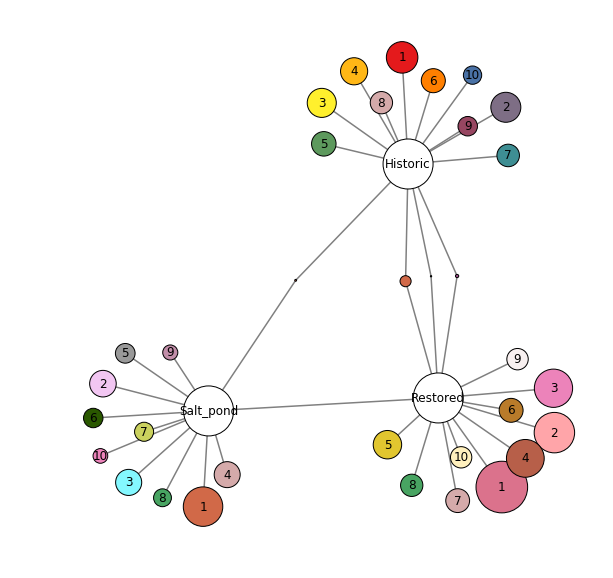

In [9]:
import networkx as nx

plt.figure(figsize=(10,10))

## select top 20 of meanbase
t1 = mean_SP_unique.nlargest(10)
t2 = mean_RS_unique.nlargest(10)
t3 = mean_HI_unique.nlargest(10)

t4 = mean_HI_RS_unique
t5 = mean_HI_SP_unique

## add to type
edges_t1 = [["Salt_pond",a+"_1"] for a in t1.index]
edges_t2 = [["Restored",a+"_2"] for a in t2.index]
edges_t3 = [["Historic",a+"_3"] for a in t3.index]

edges_t4 = [["Historic",a+"_4"] for a in t4.index] + [["Restored",a+"_4"] for a in t4.index]
edges_t5 = [["Historic",a+"_5"] for a in t5.index] + [["Salt_pond",a+"_5"] for a in t5.index]

## transform basemean to size
size1=[2500]+[a/10 for a in list(t1)]
size2=[2500]+[a/10 for a in list(t2)]
size3=[2500]+[a/10 for a in list(t3)]

size4=[a/10 for a in list(t4)]
size5=[a/10 for a in list(t5)]

edges = edges_t1+edges_t2+edges_t3+edges_t4+edges_t5+[["Salt_pond","Restored"]]

## Color Palette
dfcolor = pd.DataFrame(edges)
dfcolor[2] = [a[0] for a in dfcolor[1].str.split("_")]
family_uni = dfcolor[2].unique()[:-1]

xx = OTU_tax[["Phylum","Class","Order","Family"]].sort_values("Family")
xx = xx.groupby(["Phylum","Class","Order","Family"]).size().reset_index(name='Freq')

color_xx = pd.merge(pd.DataFrame(family_uni),xx,left_on=0,right_on="Family",how="left")
color_xx = color_xx.sort_values("Phylum")
uni_phylum = color_xx["Phylum"].unique()

colors =['#E41A1C','#4A72A6','#84f8ff','#3E8E93','#48A462','#5D995D','#974661','#A35390','#2a5800','#cad15e','#7E6E85','#D16948','#FF7F00','#FFB716','#FFF02D','#fff0bd','#E1C62F','#B97B2A','#B75F49','#ffa5a9','#DB728C','#EC83BA','#C28EA9','#d5aaaa','#f2c6f2','#f8f0f0','#d1d1d1','#999999']

color_xx["color"] = colors
color = color_xx[[0,'color']]
dfcolor2 = pd.merge(dfcolor,color,left_on=2,right_on=0,how="left")

color_final = list(dfcolor2['color'])
color_final = ["#ffffff"]+color_final[:10]+["#ffffff"]+color_final[10:20]+["#ffffff"]+color_final[20:33]+color_final[36:37]


## plot network
g = nx.Graph(edges)
#pos = nx.circular_layout(g)

## set dictionary to change node labels 
mapping = list(g.nodes())
mapping_t = mapping.copy()
mapping_t[1:11] = np.arange(1,11)
mapping_t[12:22] = np.arange(1,11)
mapping_t[23:33] = np.arange(1,11)
mapping_t[33:] = ['','','']
mapping2 = dict(zip(mapping,mapping_t))


## add size, line color, node color, change node labels
nx.draw_networkx(g,node_size=size1+size2+size3+size4+size5,edge_color='grey',node_color=color_final,width=1.5,labels=mapping2)


## set outline of node
ax = plt.gca() # to get the current axis
ax.collections[0].set_edgecolor("#000000") 

plt.axis('off') ## remove axis

## set legend
a_leng = list(color_xx[0])
b_leng = list(color_xx["color"])
legend_elements=[]

for a,b in zip(a_leng,b_leng):
    legend_elements.append(Line2D([0], [0], marker='o', color="white", label=a,markerfacecolor=b, markersize=15))

legend = plt.legend(handles=legend_elements, loc='best', bbox_to_anchor=(1, 0.5, 0.2, 0.5), prop={'size': 12}, title="Family")
plt.setp(legend.get_title(),fontsize='xx-large')


In [10]:
edges

[['Salt_pond', 'Rhodobacteraceae_1'],
 ['Salt_pond', 'Alteromonadaceae_1'],
 ['Salt_pond', 'Balneolaceae_1'],
 ['Salt_pond', 'GammaproteobacteriaCL_1'],
 ['Salt_pond', 'Spirochaetaceae_1'],
 ['Salt_pond', 'ClostridialesOR_1'],
 ['Salt_pond', 'Halanaerobiaceae_1'],
 ['Salt_pond', 'BacteroidalesOR_1'],
 ['Salt_pond', 'Desulfohalobiaceae_1'],
 ['Salt_pond', 'Sinobacteraceae_1'],
 ['Restored', 'DesulfuromonadalesOR_2'],
 ['Restored', 'Desulfobacteraceae_2'],
 ['Restored', 'Sinobacteraceae_2'],
 ['Restored', 'Desulfobulbaceae_2'],
 ['Restored', 'ChromatialesOR_2'],
 ['Restored', 'CampylobacteralesOR_2'],
 ['Restored', 'GammaproteobacteriaCL_2'],
 ['Restored', 'BacteroidalesOR_2'],
 ['Restored', 'Syntrophobacteraceae_2'],
 ['Restored', 'OM60_2'],
 ['Historic', 'AcidobacteriaPH_3'],
 ['Historic', 'GemmatimonadetesCL_3'],
 ['Historic', 'Rhodospirillaceae_3'],
 ['Historic', 'Hyphomicrobiaceae_3'],
 ['Historic', 'Rhodothermaceae_3'],
 ['Historic', 'Xanthomonadaceae_3'],
 ['Historic', 'Flavobacte

In [ ]:
#mean_SP_unique
#mean_RS_unique
mean_HI_unique

In [ ]:
#len(set([a[1].split("_")[0] for a in edges]))
dfcolor = pd.DataFrame(edges)
dfcolor[2] = [a[0] for a in dfcolor[1].str.split("_")]
family_uni = dfcolor[2].unique()[:-1]
len(family_uni)
#family_uni

In [ ]:
xx = OTU_tax[["Phylum","Class","Order","Family"]].sort_values("Family")
xx = xx.groupby(["Phylum","Class","Order","Family"]).size().reset_index(name='Freq')

color_xx = pd.merge(pd.DataFrame(family_uni),xx,left_on=0,right_on="Family",how="left")
color_xx = color_xx.sort_values("Phylum")
uni_phylum = color_xx["Phylum"].unique()
len(uni_phylum)

In [ ]:
color_xx#.groupby("Phylum").size()FirmicutesGemmatimonadetesProteobacteriaSpirochaetes

In [ ]:
colors =['#E41A1C','#4A72A6','#84f8ff','#3E8E93','#48A462','#5D995D','#974661','#A35390','#2a5800','#cad15e','#7E6E85','#D16948','#FF7F00','#FFB716','#FFF02D','#fff0bd','#E1C62F','#B97B2A','#B75F49','#ffa5a9','#DB728C','#EC83BA','#C28EA9','#d5aaaa','#f2c6f2','#f8f0f0','#d1d1d1','#999999']

sns.palplot(colors)
sns.palplot(['#e8ebea'])
len(colors)

In [ ]:
color_xx["color"] = colors
color = color_xx[[0,'color']]
dfcolor2 = pd.merge(dfcolor,color,left_on=2,right_on=0,how="left")
dfcolor2

In [ ]:
color_final = list(dfcolor2['color'])
color_final = ["#ffffff"]+color_final[:10]+["#ffffff"]+color_final[10:20]+["#ffffff"]+color_final[20:33]+color_final[36:37]
color_final